In [61]:
from scipy import io
import pprint
import numpy as np
import matplotlib.pyplot as plt
import time

In [62]:
class calculatePose:
    def __init__(self, viconDataPath: str, imuDataPath: str, imuParamPath: str) -> None:
        viconDataLoader = io.loadmat(viconDataPath)
        viconTS = viconDataLoader["ts"]
        viconTS = viconTS[0]
        # print(viconTS)
        viconData = viconDataLoader[
            "rots"
        ]  # Rotation Matrix with Z-Y-X Euler Angles Rotation
        # pprint.pprint(viconData)

        imuDataLoader = io.loadmat(imuDataPath)
        IMUTS = imuDataLoader["ts"]
        IMUTS = IMUTS[0]
        IMUData = imuDataLoader["vals"]  # [ax ay az wz wx wy]^T
        # pprint.pprint(IMUTS)
        # pprint.pprint(IMUData)

        imuParamLoader = io.loadmat(imuParamPath)
        imuParams = imuParamLoader["IMUParams"]

        self.performIMUAttitudeEstimation(IMUTS, IMUData, imuParams, viconTS, viconData)

    def calculateBias(self, IMUData):
        wxTotal = 0
        wyTotal = 0
        wzTotal = 0
        totalIterations = 300
        for i in range(totalIterations):
            imuData = [
                IMUData[3, i],
                IMUData[4, i],
                IMUData[5, i],
            ]
            wz, wx, wy = imuData
            wxTotal += wx
            wyTotal += wy
            wzTotal += wz
        bgx = wxTotal / totalIterations
        bgy = wyTotal / totalIterations
        bgz = wzTotal / totalIterations
        return bgx, bgy, bgz

    def convertRawValuesToSIUnits(
        self, IMUData, bax, bay, baz, sx, sy, sz, bgx, bgy, bgz
    ):
        """Convert the RAW Sensor Values of Accelerometer and GyroScope to SI Unit Values.

        Args:
            IMUData (np.array): NP Array of IMU Data [ax,ay,az,wz,wx,wy]
            bax (float): Accelerometer Bias Along X Axis
            bay (float): Accelerometer Bias Along Y Axis
            baz (float): Accelerometer Bias Along Z Axis
            sx (float): Accelerometer Scale Factor Along X Axis
            sy (float): Accelerometer Scale Factor Along Y Axis
            sz (float): Accelerometer Scale Factor Along Z Axis
            bgx (float): Gyroscope Bias Along X Axis
            bgy (float): Gyroscope Bias Along Y Axis
            bgz (float): Gyroscope Bias Along Z Axis

        Returns:
            np.array(float): NP Array of SI Unit Values of Accelerometer(m/s2) and Gyroscope(rad/s)
            [ax,ay,az,wx,wy,wz]
        """
        adjustedIMUData = np.zeros(
            (len(IMUData[0]), 6), dtype=float
        )  # t,ax,zy,az, wx,wy,wz
        for i in range(len(IMUData[0])):
            imuData = [
                IMUData[0, i],
                IMUData[1, i],
                IMUData[2, i],
                IMUData[3, i],
                IMUData[4, i],
                IMUData[5, i],
            ]
            # pprint.pprint(imuData)
            ax, ay, az, wz, wx, wy = imuData
            tilde_ax = (ax + bax) / sx
            tilde_ay = (ay + bay) / sy
            tilde_az = (az + baz) / sz

            tilde_wx = (3300 / 1023) * (np.pi / 180) * 0.3 * (wx - bgx)
            tilde_wy = (3300 / 1023) * (np.pi / 180) * 0.3 * (wy - bgy)
            tilde_wz = (3300 / 1023) * (np.pi / 180) * 0.3 * (wz - bgz)

            adjustedIMUData[i] = (
                tilde_ax,
                tilde_ay,
                tilde_az,
                tilde_wx,
                tilde_wy,
                tilde_wz,
            )
        return adjustedIMUData

    def convertRotZYXToEulerAngles(self, viconData):
        """Convert the Vicon 3x3 Rotation Matrix to XYZ Euler Anglers

        Args:
            viconData (np.array(float)): Vicon Rotation Matrix in ZYX Euler Angle Format

        Returns:
            np.array(float): Vicon Data in XYZ Euler Format
        """
        eulerViconData = np.zeros((len(viconData), 3), dtype=float)
        for i, R in enumerate(viconData):
            sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
            singular = sy < 1e-6
            if not singular:
                x = np.arctan2(R[2, 1], R[2, 2])
                y = np.arctan2(-R[2, 0], sy)
                z = np.arctan2(R[1, 0], R[0, 0])
            else:
                x = np.arctan2(-R[1, 2], R[1, 1])
                y = np.arctan2(-R[2, 0], sy)
                z = 0
            eulerViconData[i] = x, y, z
        return eulerViconData

    def alignData(self, imuTS, imuData, viconTS, viconData):
        useIMUTS = True

        if viconTS[0] > imuTS[0]:
            print("Vicon Initializes First. Using Vicon TS as base")
            useIMUTS = False
        else:
            print("IMU Initializes First. Using IMU TS as base")

        # if(useIMUTS):
        #     for i in range(len(imuTS)-1):
        # TODO: Write a data alignment code using SLERP
        pass

    def computeOrientationFromGyroscope(
        self, imuTs, imuData, bgx, bgy, bgz, viconInitialPose
    ):
        orientation = np.zeros(((len(imuData)), 3), dtype=float)
        TS = np.zeros((len(imuData) + 1), dtype=float)
        orientation[0] = viconInitialPose

        lastTs = imuTs[0]
        mean = 0  # Mean of the distribution
        std_dev = 1  # Standard deviation
        num_samples = 100  # Number of samples
        ngx = np.mean(np.random.normal(mean, std_dev, num_samples))
        ngy = np.mean(np.random.normal(mean, std_dev, num_samples))
        ngz = np.mean(np.random.normal(mean, std_dev, num_samples))

        for i, imuVal in enumerate(imuData[1:], start=1):
            _, _, _, wx, wy, wz = imuVal

            wHatX = wx - bgx - ngx
            wHatY = wy - bgy - ngy
            wHatZ = wz - bgz - ngz
            t = imuTs[i] - lastTs
            deltaThetaX = wHatX * t
            deltaThetaY = wHatY * t
            deltaThetaZ = wHatZ * t

            orientation[i, 0] = deltaThetaX + orientation[i - 1, 0]
            orientation[i, 1] = deltaThetaY + orientation[i - 1, 1]
            orientation[i, 2] = deltaThetaZ + orientation[i - 1, 2]
            lastTs = imuTs[i]
        return orientation

    def computeOrientationFromAccelerometer(
        self, imuTs, imuData, bax, bay, baz, viconInitialPose
    ):
        gravity = np.array([0, 0, -9.8])

        orientation = np.zeros(((len(imuData)), 3), dtype=float)
        TS = np.zeros((len(imuData) + 1), dtype=float)
        orientation[0] = viconInitialPose

        lastTs = imuTs[0]
        mean = 0  # Mean of the distribution
        std_dev = 1  # Standard deviation
        num_samples = 100  # Number of samples
        ngx = np.mean(np.random.normal(mean, std_dev, num_samples))
        ngy = np.mean(np.random.normal(mean, std_dev, num_samples))
        ngz = np.mean(np.random.normal(mean, std_dev, num_samples))

        for i, imuVal in enumerate(imuData[1:], start=1):
            _, _, _, wx, wy, wz = imuVal

            wHatX = wx - bax - ngx
            wHatY = wy - bay - ngy
            wHatZ = wz - baz - ngz
            t = imuTs[i] - lastTs
            deltaThetaX = wHatX * t
            deltaThetaY = wHatY * t
            deltaThetaZ = wHatZ * t

            orientation[i, 0] = deltaThetaX + orientation[i - 1, 0]
            orientation[i, 1] = deltaThetaY + orientation[i - 1, 1]
            orientation[i, 2] = deltaThetaZ + orientation[i - 1, 2]
            lastTs = imuTs[i]
        return orientation

    def performIMUAttitudeEstimation(
        self, imuTS, IMUData, imuParams, viconTS, viconData
    ):
        scaleParams, biasParams = imuParams
        sx, sy, sz = scaleParams
        bax, bay, baz = biasParams
        bgx, bgy, bgz = self.calculateBias(IMUData)

        metricIMUData = self.convertRawValuesToSIUnits(
            IMUData, bax, bay, baz, sx, sy, sz, bgx, bgy, bgz
        )

        eulerViconData = self.convertRotZYXToEulerAngles(viconData)
        # TODO: Currently we are not working using aligned Data
        # alignedData = self.alignData(imuTS, metricIMUData, viconTS, eulerViconData)

        gyroOnlyPose = self.computeOrientationFromGyroscope(
            imuTS, metricIMUData, bgx, bgy, bgz, eulerViconData[0]
        )
        plt.plot(imuTS, gyroOnlyPose[:, 2])
        plt.title("Simple Plot")
        plt.xlabel("x-axis")
        plt.ylabel("y-axis")
        plt.show()

        accelOnlyPose = self.computeOrientationFromAccelerometer(
            imuTS, metricIMUData, bax, bay, baz, eulerViconData[0]
        )
        plt.plot(imuTS, accelOnlyPose[:, 2])
        plt.title("Simple Plot")
        plt.xlabel("x-axis")
        plt.ylabel("y-axis")
        plt.show()

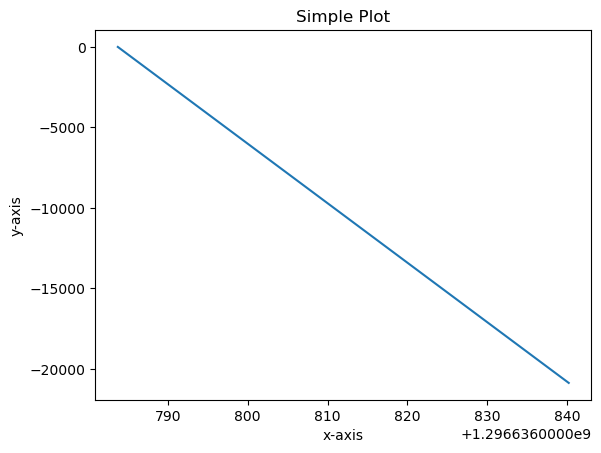

In [63]:
set1 = calculatePose(
    "Phase1/Data/Train/Vicon/viconRot1.mat",
    "Phase1/Data/Train/IMU/imuRaw1.mat",
    "Phase1/IMUParams.mat",
)

# set2 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot2.mat",
#     "Phase1/Data/Train/IMU/imuRaw2.mat",
#     "Phase1/IMUParams.mat",
# )

# set3 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot3.mat",
#     "Phase1/Data/Train/IMU/imuRaw3.mat",
#     "Phase1/IMUParams.mat",
# )

# set4 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot4.mat",
#     "Phase1/Data/Train/IMU/imuRaw4.mat",
#     "Phase1/IMUParams.mat",
# )

# set5 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot5.mat",
#     "Phase1/Data/Train/IMU/imuRaw5.mat",
#     "Phase1/IMUParams.mat",
# )

# set6 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot6.mat",
#     "Phase1/Data/Train/IMU/imuRaw6.mat",
#     "Phase1/IMUParams.mat",
# )